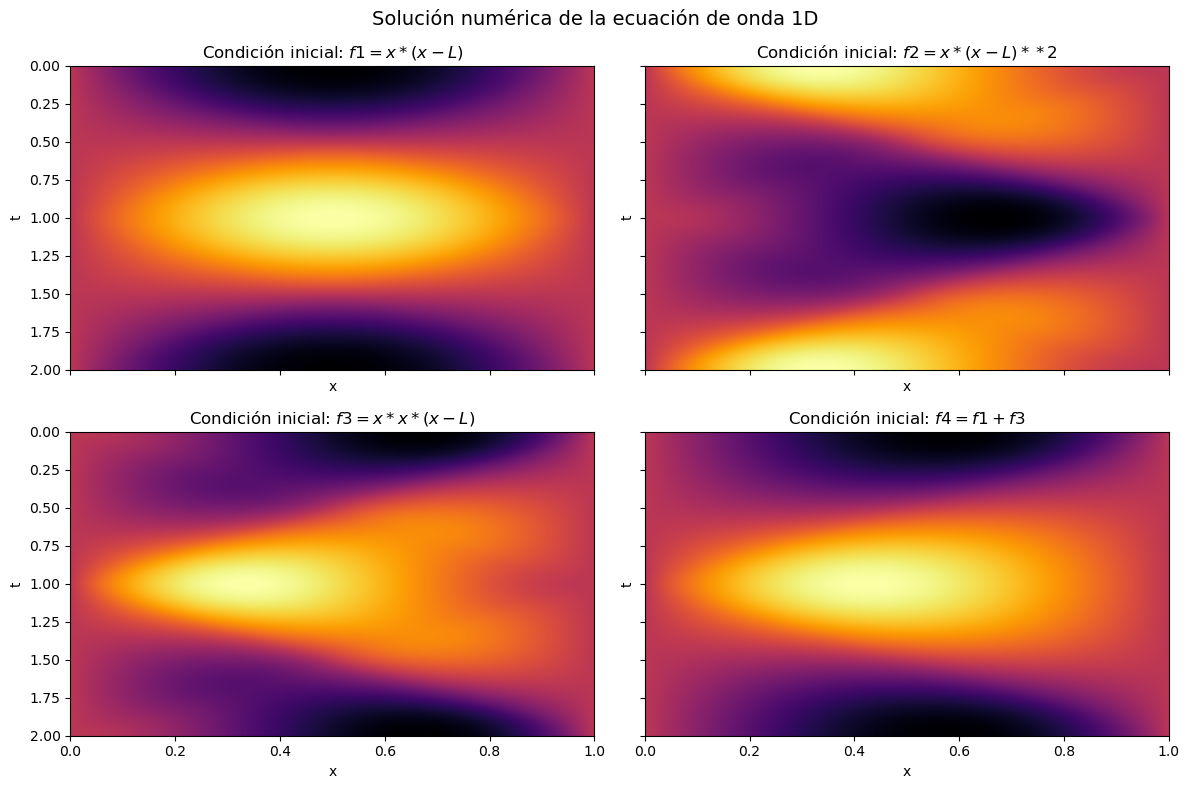

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos y numéricos
L = 1.0  # Longitud del dominio
T = 2.0  # Tiempo total de simulación
c = 1.0  # Velocidad de propagación

Nx = 1000  # Número de puntos espaciales
Nt = 5000  # Número de pasos temporales

dx = L / Nx
dt = T / Nt

x = np.linspace(0, L, Nx + 1)
t = np.linspace(0, T, Nt + 1)
r = c * dt / dx

assert r <= 1, f"Condición CFL no satisfecha: r = {r}"

# Lista de funciones iniciales y etiquetas
funcs = [
    (lambda x: x * (x - L), r"$f1 = x * (x - L)$"),
    (lambda x: x * (x - L) ** 2, r"$f2 = x*(x-L)**2$"),
    (lambda x: x * x * (x - L), r"$f3 = x * x * (x - L)$"),
    (lambda x: x * (x - L) + x * x * (x - L), r"$f4 = f1 + f3$"),
]


def solve_wave(f):
    """Resuelve la ecuación de onda 1D para una función inicial f(x)"""
    u0 = f(x)
    u = np.zeros((Nt + 1, Nx + 1))
    u[0, :] = u0
    # Primer paso temporal
    u[1, 1:-1] = u0[1:-1] + 0.5 * r**2 * (u0[2:] - 2 * u0[1:-1] + u0[:-2])
    # Iteración en el tiempo
    for n in range(1, Nt):
        u[n + 1, 1:-1] = (
            2 * (1 - r**2) * u[n, 1:-1] - u[n - 1, 1:-1] + r**2 * (u[n, 2:] + u[n, :-2])
        )
    return u


# Crear figura de mapas de calor
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (f, label) in enumerate(funcs):
    u = solve_wave(f)
    im = axes[i].imshow(u, extent=[0, L, T, 0], aspect="auto", cmap="inferno")
    axes[i].set_title(f"Condición inicial: {label}", fontsize=12)
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("t")

# Agregar barra de color común
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, label='u(x,t)')
plt.suptitle("Solución numérica de la ecuación de onda 1D", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm

# Crear directorio de salida
os.makedirs("wave_solutions", exist_ok=True)

# Parámetros físicos y numéricos
L = 1.0
T = 2.0
c = 1.0

Nx = 100
Nt = 500

dx = L / Nx
dt = T / Nt

x = np.linspace(0, L, Nx + 1)
t = np.linspace(0, T, Nt + 1)
r = c * dt / dx

assert r <= 1, f"Condición CFL no satisfecha: r = {r}"

# Lista de funciones iniciales y etiquetas
ks = [1, 2, 3, 4]
funcs = [(lambda x, k=k: np.sin(k * np.pi * x), k) for k in ks]


def solve_wave(f):
    u0 = f(x)
    u = np.zeros((Nt + 1, Nx + 1))
    u[0, :] = u0
    u[1, 1:-1] = u0[1:-1] + 0.5 * r**2 * (u0[2:] - 2 * u0[1:-1] + u0[:-2])
    for n in range(1, Nt):
        u[n + 1, 1:-1] = (
            2 * (1 - r**2) * u[n, 1:-1] - u[n - 1, 1:-1] + r**2 * (u[n, 2:] + u[n, :-2])
        )
    return u


# Resolver y guardar como tensores torch para cada k
for f, k in tqdm(funcs):
    u = solve_wave(f)
    u_tensor = torch.tensor(u, dtype=torch.float32)  # (Nt+1, Nx+1)
    f_tensor = torch.tensor(f(x), dtype=torch.float32)
    data = {
        "u": u_tensor,  # solución espacio-tiempo
        "x": torch.tensor(x),  # grid espacial
        "t": torch.tensor(t),  # grid temporal
        "f_x": torch.tensor(f_tensor),  # frecuencia inicial
        "k": int(k),  # frecuencia inicial
    }
    torch.save(data, f"wave_solutions/u_wave_k{k}.pt")

print("✅ Soluciones guardadas en `wave_solutions/`.")

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_3833910/363227420.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "f_x": torch.tensor(f_tensor),  # frecuencia inicial
100%|██████████| 4/4 [00:00<00:00, 21.64it/s]

✅ Soluciones guardadas en `wave_solutions/`.


/tmp/ipykernel_3833910/1352823202.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("wave_solutions/u_wave_k3.pt")


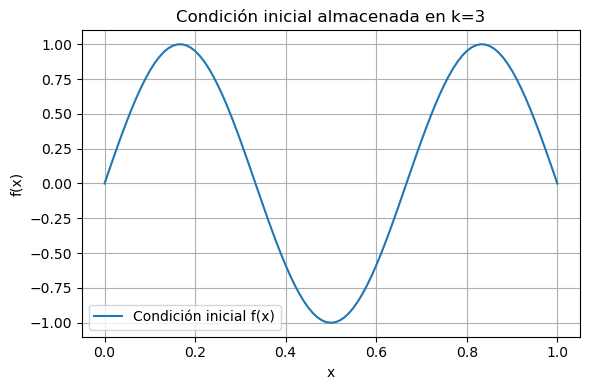

In [14]:
# Cargar una muestra

data = torch.load("wave_solutions/u_wave_k3.pt")

f_x = data["f_x"]  # Este es f(x), guardado como un vector
x = data["x"]
k = data["k"]
plt.figure(figsize=(6, 4))
plt.plot(x, f_x, label="Condición inicial f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(f"Condición inicial almacenada en k={k}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

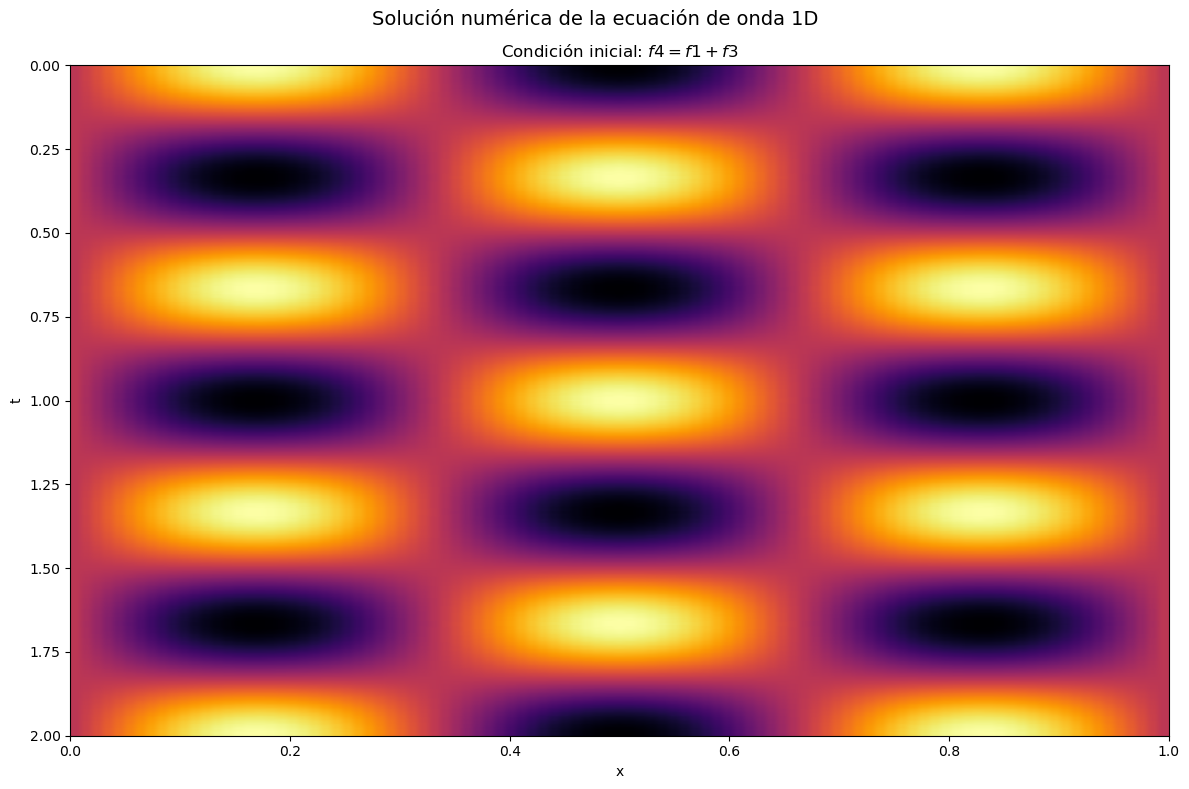

In [15]:
u = data["u"]

# Crear figura de mapas de calor
fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True)
im = axes.imshow(u, extent=[0, L, T, 0], aspect="auto", cmap="inferno")
axes.set_title(f"Condición inicial: {label}", fontsize=12)
axes.set_xlabel("x")
axes.set_ylabel("t")

# Agregar barra de color común
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9, label='u(x,t)')
plt.suptitle("Solución numérica de la ecuación de onda 1D", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
data["t"][-1]

tensor(2., dtype=torch.float64)